# Inicializacion

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML
from scipy.stats import spearmanr


# Importacion de datos

In [2]:
# Importamos archivos
df_contract = pd.read_csv("datasets/final_provider/contract.csv")
df_internet = pd.read_csv("datasets/final_provider/internet.csv")
df_personal = pd.read_csv("datasets/final_provider/personal.csv")
df_phone = pd.read_csv("datasets/final_provider/phone.csv")

# EDA

## Mostrar informacion de los dataframes

In [9]:
# Contracts ------------------------|
display(HTML('<h1> Contracts'))
display(df_contract.sample(10))
display(df_contract.info())
display(df_contract.describe())
display(HTML('<h2> Verificar datos nulos'))
display(df_contract.isnull().sum())
display(HTML('<h2> Verificar duplicados'))
display(df_contract.duplicated().sum())
display(HTML('<hr>'))

# Internet -------------------------|
display(HTML('<h1> Internet'))
display(df_internet.sample(10))
display(df_internet.info())
display(df_internet.describe())
display(HTML('<h2> Verificar datos nulos'))
display(df_internet.isnull().sum())
display(HTML('<h2> Verificar duplicados'))
display(df_internet.duplicated().sum())
display(HTML('<hr>'))

# Personal -------------------------|
display(HTML('<h1> Personal'))
display(df_personal.sample(10))
display(df_personal.info())
display(df_personal.describe())
display(HTML('<h2> Verificar datos nulos'))
display(df_personal.isnull().sum())
display(HTML('<h2> Verificar duplicados'))
display(df_personal.duplicated().sum())
display(HTML('<hr>'))

# Phone ----------------------------|
display(HTML('<h1> Phone'))
display(df_phone.sample(10))
display(df_phone.info())
display(df_phone.describe())
display(HTML('<h2> Verificar datos nulos'))
display(df_phone.isnull().sum())
display(HTML('<h2> Verificar duplicados'))
display(df_phone.duplicated().sum())
display(HTML('<hr>'))



,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
1404,1970-KKFWL,2017-03-01,No,Two year,No,Bank transfer (automatic),23.30,797.1
79,3887-PBQAO,2016-05-01,No,One year,Yes,Credit card (automatic),25.90,1216.6
1996,9993-LHIEB,2014-07-01,No,Two year,No,Mailed check,67.85,4627.65
6815,0270-THENM,2014-02-01,No,Two year,No,Bank transfer (automatic),69.85,5102.35
2525,3133-PZNSR,2014-02-01,No,Two year,Yes,Credit card (automatic),97.75,6991.6
2864,1564-HJUVY,2019-10-01,No,Month-to-month,Yes,Bank transfer (automatic),63.75,226.2
6740,7957-RYHQD,2016-09-01,2020-01-01 00:00:00,Month-to-month,Yes,Credit card (automatic),79.20,3233.85
5524,1716-LSAMB,2016-05-01,No,Two year,No,Bank transfer (automatic),54.65,2553.7
6358,1027-LKKQQ,2014-02-01,No,Two year,Yes,Bank transfer (automatic),80.45,5886.85
7030,0871-OPBXW,2019-12-01,No,Month-to-month,Yes,Mailed check,20.05,39.25


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

0

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
3782,0931-MHTEM,Fiber optic,Yes,Yes,No,No,Yes,Yes
2658,4806-DXQCE,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes
38,4080-IIARD,DSL,Yes,Yes,No,Yes,Yes,No
3666,5855-EIBDE,Fiber optic,Yes,Yes,Yes,Yes,No,Yes
3522,3633-CDBUW,DSL,No,Yes,Yes,Yes,Yes,Yes
4678,9661-ACXBS,Fiber optic,Yes,No,Yes,No,Yes,Yes
2112,5213-TWWJU,Fiber optic,No,No,Yes,Yes,No,Yes
2008,1849-RJYIG,DSL,Yes,No,No,No,Yes,No
4919,2754-XBHTB,Fiber optic,No,No,No,No,Yes,No
2965,2386-OWURY,Fiber optic,No,No,No,Yes,Yes,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

0

,customerID,gender,SeniorCitizen,Partner,Dependents
2642,2195-ZRVAX,Female,0,Yes,No
3711,4877-TSOFF,Female,0,Yes,Yes
4966,3097-IDVPU,Male,0,Yes,Yes
4441,4825-FUREZ,Male,0,Yes,No
3957,2019-HDCZY,Male,0,Yes,No
4954,9725-SCPZG,Male,0,No,Yes
3729,3635-QQRQD,Male,0,No,No
6671,5090-EMGTC,Female,0,Yes,No
6329,6603-QWSPR,Female,0,No,No
1439,0506-LVNGN,Female,1,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

0

,customerID,MultipleLines
2843,5222-JCXZT,No
2546,1023-BQXZE,No
2284,9067-YGSCA,Yes
921,3863-IUBJR,No
2504,3948-KXDUF,Yes
1700,7105-MXJLL,No
6294,7789-CRUVC,Yes
5613,5716-LIBJC,Yes
5634,1599-MMYRQ,No
2841,6692-YQHXC,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


customerID       0
MultipleLines    0
dtype: int64

0

In [10]:
# Convertir BeginDate y EndDate a datetime
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'])
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'], errors='coerce')

# Calcular la duración del contrato en meses
df_contract['ContractDuration'] = ((df_contract['EndDate'] - df_contract['BeginDate']).dt.days / 30).fillna((pd.Timestamp('today') - df_contract['BeginDate']).dt.days / 30)


C:\Users\Eduardo\AppData\Local\Temp\ipykernel_1812\3137423287.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'], errors='coerce')


C:\Users\Eduardo\AppData\Local\Temp\ipykernel_1812\2427221153.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cancellation_rates = df_contract[df_contract['EndDate'].notna()].groupby('DurationCategory').size() / df_contract.groupby('DurationCategory').size()
C:\Users\Eduardo\AppData\Local\Temp\ipykernel_1812\2427221153.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cancellation_rates = df_contract[df_contract['EndDate'].notna()].groupby('DurationCategory').size() / df_contract.groupby('DurationCategory').size()


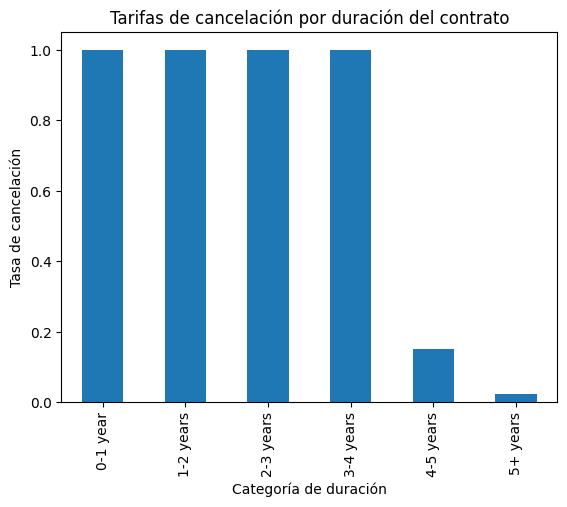

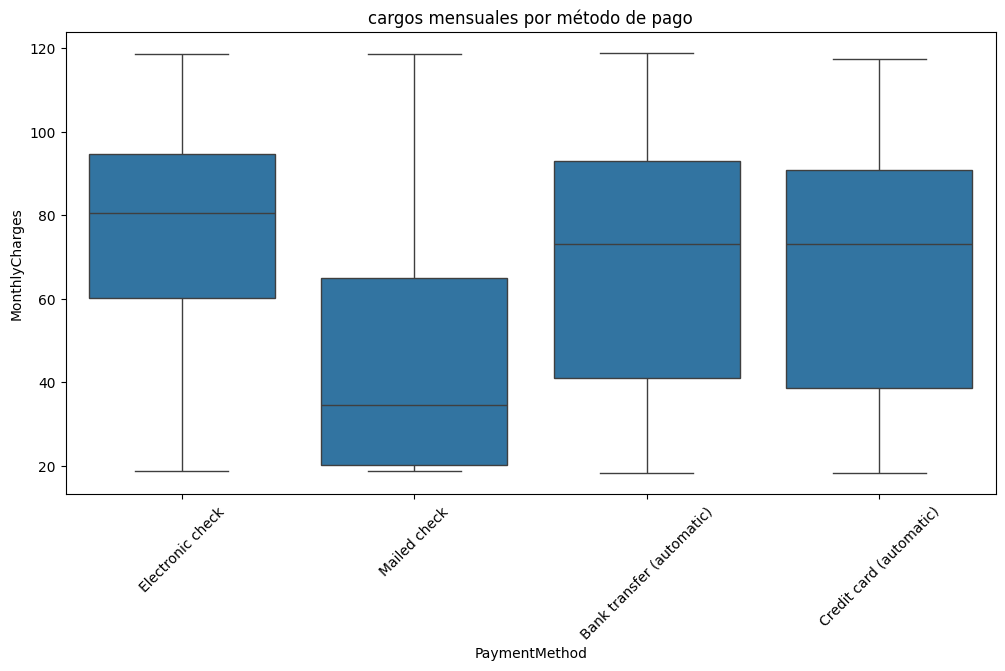

In [14]:
# Categorizar la duración del contrato para facilitar la visualización
df_contract['DurationCategory'] = pd.cut(df_contract['ContractDuration'], bins=[0, 12, 24, 36, 48, 60, np.inf], labels=['0-1 year', '1-2 years', '2-3 years', '3-4 years', '4-5 years', '5+ years'])

# Gráfico de barras para ver la tasa de cancelación por categoría de duración
cancellation_rates = df_contract[df_contract['EndDate'].notna()].groupby('DurationCategory').size() / df_contract.groupby('DurationCategory').size()
cancellation_rates.plot(kind='bar')
plt.title('Tarifas de cancelación por duración del contrato')
plt.ylabel('Tasa de cancelación')
plt.xlabel('Categoría de duración')
plt.show()

# Boxplot de cargos mensuales por método de pago
plt.figure(figsize=(12, 6))
sns.boxplot(x='PaymentMethod', y='MonthlyCharges', data=df_contract)
plt.title('cargos mensuales por método de pago')
plt.xticks(rotation=45)
plt.show()


In [13]:
# Correlación de Spearman
correlation, p_value = spearmanr(df_contract['ContractDuration'], df_contract['EndDate'].notna())
print(f'Correlation Coefficient: {correlation}, P-value: {p_value}')


Correlation Coefficient: -0.7412748528033855, P-value: 0.0
